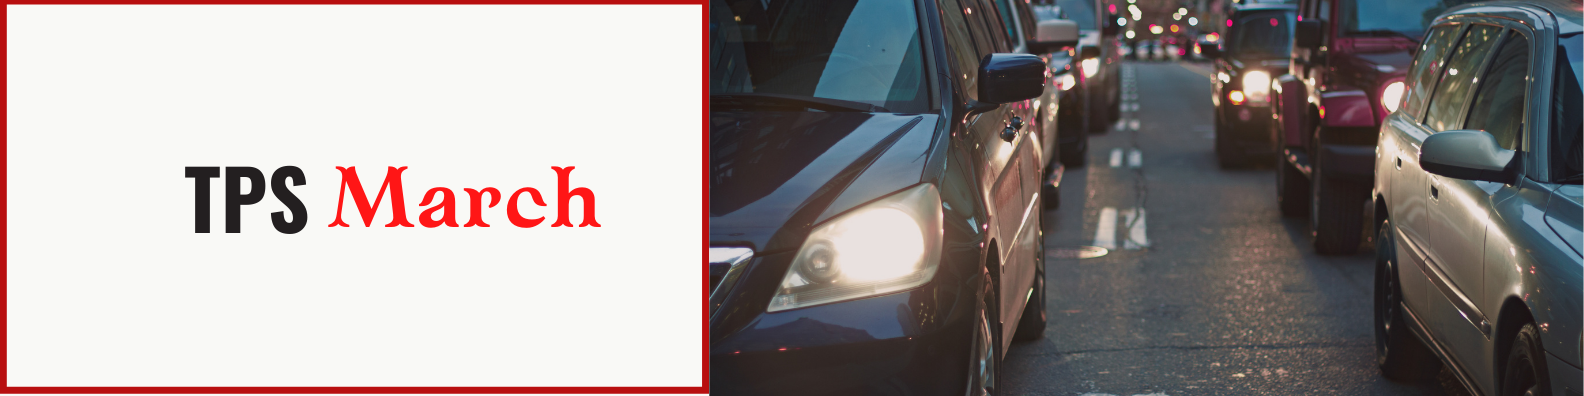

<p style="font-family: Arials; font-size: 20px;text-align: center;; font-style: normal;line-height:1.3">In this challenge, you will forecast traffic flow in a big U.S. metropolitan region for twelve hours. You can model interactions over a network of highways using time, location, and directional information.</p>

**Observations on this TPS dataset:**
- `congestion` column is the target variable which consists of congestion levels for the roadway during each hour.   The congestion measurements have been normalized to the range 0 to 100

- `Train` dataset has `848,835` rows and `6` columns which contains`4` features, `1` target variable `target` and `1` column of `row_id`
- `Test` dataset has `2340` rows and `5` columns which contains`4` features with`1` column of `row_id`
- No missing values in train and test dataset

**Training File Description:**

The training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991.

- `row_id` column is a unique identifier for each instance
- `time` column is the 20-minute period in which each measurement was taken
- `x` column is the east-west midpoint coordinate of the roadway
- `y` column is the north-south midpoint coordinate of the roadway
- `direction` column is the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel
- `congestion` column is the congestion levels for the roadway during each hour

**Test File**
: You will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.

### <h3 style="background-color:#ff8fa3;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Importing Libraries & Packages 📚 </centre></strong></h3>

In [ ]:
!pip install hvplot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import holoviews as hv
import hvplot.pandas  
hv.extension('bokeh')
import holoviews as hv
from holoviews import opts
from bokeh.models import HoverTool

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Reference: https://www.kaggle.com/c/tabular-playground-series-oct-2021/discussion/275854
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### <h3 style="background-color:#ff8fa3;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Importing & Reading the dataset 📝 </centre></strong></h3>

In [ ]:
df_train = pd.read_csv("../input/tabular-playground-series-mar-2022/train.csv")
reduce_mem_usage(df_train)
df_test = pd.read_csv("../input/tabular-playground-series-mar-2022/test.csv")
reduce_mem_usage(df_test)
df_subm = pd.read_csv("../input/tabular-playground-series-mar-2022/sample_submission.csv")

In [ ]:
#Custom Color Palette 🎨
custom_colors = ["#d81159","#ffee32","#9381ff","#7bf1a8","#ef6351","#42a5f5","#f20089","#8ac926"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

In [ ]:
df_train_row_count, df_train_column_count = df_train.shape
print('Total number of rows:', df_train_row_count) 
print('Total number of columns:', df_train_column_count)

In [ ]:
df_test_row_count, df_test_column_count = df_test.shape
print('Total number of rows:', df_test_row_count)
print('Total number of columns:', df_test_column_count) 

In [ ]:
df_train.head()

In [ ]:
df_train.describe().T

In [ ]:
df_train['time'] = pd.to_datetime(df_train['time'])
df_train['year'] = df_train['time'].dt.year
df_train['month'] = df_train['time'].dt.month
df_train['day'] = df_train['time'].dt.day
df_train['x+y'] = df_train['x'].astype('str') + df_train['y'].astype('str')
df_train['day_of_yr'] = df_train['time'].dt.dayofyear
df_train['day_of_week'] = df_train['time'].dt.dayofweek
df_train['is_weekend'] = (df_train['time'].dt.dayofweek > 4).astype('int')
df_train['hour'] = df_train['time'].dt.hour
df_train['minute'] = df_train['time'].dt.minute
df_train['is_afternoon'] = (df_train['hour'] > 12).astype('int')
df_train["hour+minute"] = df_train['time'].dt.hour*60 + df_train['time'].dt.minute
df_train['hour+direction'] = df_train['hour'].astype('str') + df_train['direction'].astype('str')
df_train['x+direction'] = df_train['x'].astype('str') + df_train['direction'].astype('str')
df_train['y+direction'] = df_train['y'].astype('str') + df_train['direction'].astype('str')
print(df_train.info())

In [ ]:
df_test['time'] = pd.to_datetime(df_test['time'])
df_test['year'] = df_test['time'].dt.year
df_test['month'] = df_test['time'].dt.month
df_test['day'] = df_test['time'].dt.day
df_test['x+y'] = df_test['x'].astype('str') + df_test['y'].astype('str')
df_test['day_of_yr'] = df_test['time'].dt.dayofyear
df_test['day_of_week'] = df_test['time'].dt.dayofweek
df_test['is_weekend'] = (df_test['time'].dt.dayofweek > 4).astype('int')
df_test['hour'] = df_test['time'].dt.hour
df_test['minute'] = df_test['time'].dt.minute
df_test['is_afternoon'] = (df_test['hour'] > 12).astype('int')
df_test["hour+minute"] = df_test['time'].dt.hour*60 + df_test['time'].dt.minute
df_test['hour+direction'] = df_test['hour'].astype('str') + df_test['direction'].astype('str')
df_test['x+direction'] = df_test['x'].astype('str') + df_test['direction'].astype('str')
df_test['y+direction'] = df_test['y'].astype('str') + df_test['direction'].astype('str')
print(df_test.info())

In [ ]:
df_train[['direction','hour+direction','x+direction','y+direction']] = df_train[['direction','hour+direction','x+direction','y+direction']].astype('category')
df_test[['direction','hour+direction','x+direction','y+direction']] = df_test[['direction','hour+direction','x+direction','y+direction']].astype('category')
df_train[['x+y']] = df_train[['x+y']].astype('int')
df_test[['x+y']] = df_test[['x+y']].astype('int')

In [ ]:
df_train.dtypes

In [ ]:
print('Duration (Train Date): ', df_train['time'].min(), df_train['time'].max())
print('Duration (Test Date): ', df_test['time'].min(), df_test['time'].max())
print('(Train) Days: ',(df_train['time'].max() - df_train['time'].min()))

### <h3 style="background-color:#ff8fa3;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Checking for missing values ✏️ </centre></strong></h3>

In [ ]:
df_train.isna().sum()

In [ ]:
df_test.isna().sum()

In [ ]:
print ("Unique values are:\n",df_train.nunique().sort_values(ascending =False))

In [ ]:
np.unique(df_train.congestion)

In [ ]:
# Dropping not necessary Id column
df_train.drop(columns ='row_id',inplace=True)
df_test.drop(columns ='row_id',inplace=True)

Using Holoviews & Bokeh for visualization

In [ ]:
hv.Distribution(df_train['congestion']).opts(opts.Distribution(title="Congestion Distribution", xlabel="Congestion Value", ylabel="Density", width=700, height=300,tools=['hover'],show_grid=True))

In [ ]:
df_hourly = df_train.set_index('time').resample('H').mean().reset_index()
df_daily = df_train.set_index('time').resample('D').mean().reset_index()
df_weekly = df_train.set_index('time').resample('W').mean().reset_index()

In [ ]:
hv.Bars(df_hourly[['congestion','day']].groupby('day').mean()).opts(
    opts.Bars(title="Congestion by Day", xlabel="", ylabel="Congestion",
               width=1000, height=300,tools=['hover'],show_grid=True))

In [ ]:
hv.Curve(df_hourly[['congestion','month']].groupby('month').mean()).opts(
    opts.Curve(title="Monthly Congestion", xlabel="Month", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))

In [ ]:
data = pd.get_dummies(df_train, columns = ['direction'])

In [ ]:
data.drop(columns =['year','month','day','day_of_yr','day_of_week','hour','minute','hour+minute','is_weekend','is_afternoon'],inplace=True)
cols = data.columns
plt.figure(figsize = (11, 11))
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask = mask,cmap = custom_colors,robust=True, center=0,square=True, annot = True,linewidths=.6,fmt = ".2f")
plt.title('Correlation')
plt.show()

In [ ]:
direct = pd.DataFrame({'count': df_train.direction.value_counts(),
                             'percentage': df_train['direction'].value_counts() / df_train.shape[0] * 100
})

In [ ]:
direct

In [ ]:
direct_tr = df_train.direction.value_counts()
direct_df = pd.DataFrame({'Directions': direct_tr.index.tolist(), 'Count': direct_tr})
direct_df.reset_index(drop=True, inplace=True)
direct_df.hvplot.bar(x='Directions', y='Count',height=400, width=700)

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df_train['direction'] = df_train[['direction']].apply(enc.fit_transform)
df_test['direction'] = df_test[['direction']].apply(enc.fit_transform)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df_train['direction'])
df_train['direction'] = label_encoder.transform(df_train['direction'])
df_test['direction'] = label_encoder.transform(df_test['direction'])

### <h3 style="background-color:#ff8fa3;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Dataset split ⏳  </centre></strong></h3>

In [ ]:
df_train = df_train.drop('time', axis='columns')

In [ ]:
# define dataset
X = df_train.drop(['congestion'], axis=1)
y = df_train['congestion']

In [ ]:
# creating dataset split for prediction
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state = 42) # 80-20 split

# Checking split 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

### <h3 style="background-color:#ff8fa3;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>XGBoost ✏️ </centre></strong></h3>

In [ ]:
from xgboost import XGBRegressor
model1 = XGBRegressor(random_state=42,n_estimators= 500,learning_rate=0.05,
                      max_depth=8,booster='gbtree',verbosity=1,tree_method = 'gpu_hist',task_type ="GPU",enable_categorical=True, use_label_encoder=False)
model1.fit(X,y)

In [ ]:
from sklearn import metrics
predicted1 = model1.predict(X)

mae = metrics.mean_absolute_error(y, predicted1)
mse = metrics.mean_squared_error(y, predicted1)
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(y,predicted1)

print("XGBoost Metrics:")
print("mae:",mae)
print("mse:", mse)
print("rmse:", rmse)
print("r2:", r2)

In [ ]:
df_test = df_test.drop('time', axis='columns')

In [ ]:
y_pred1 = model1.predict(df_test)

In [ ]:
df_imp = pd.DataFrame({'feature': X_train.columns, 'importance': model1.feature_importances_})
plt.figure(figsize = (12,7))
sns.barplot(x="importance", y="feature", data = df_imp.sort_values(by ="importance", ascending = False).iloc[:20],
           palette = custom_colors)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
df_subm.congestion = y_pred1
df_subm

In [ ]:
df_subm.to_csv('submission_xgb.csv', index=False)

### <h3 style="background-color:#ff8fa3;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>LGBM ✏️ </centre></strong></h3>

In [ ]:
from lightgbm import LGBMRegressor
model3 = LGBMRegressor(random_state=42,n_estimators= 500,learning_rate=0.05,
                       objective='regression',max_depth=5, n_jobs = -1)
model3.fit(X,y, verbose=1)

In [ ]:
from sklearn import metrics
predicted3 = model3.predict(X)

mae = metrics.mean_absolute_error(y, predicted3)
mse = metrics.mean_squared_error(y, predicted3)
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(y,predicted3)

print("LightGBM Metrics:")
print("mae:",mae)
print("mse:", mse)
print("rmse:", rmse)
print("r2:", r2)

In [ ]:
y_pred3 = model3.predict(df_test)

In [ ]:
df_imp = pd.DataFrame({'feature': X_train.columns, 'importance': model3.feature_importances_})
plt.figure(figsize = (12,7))
sns.barplot(x="importance", y="feature", data = df_imp.sort_values(by ="importance", ascending = False).iloc[:20],
           palette = custom_colors)
plt.title("LGBM Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
df_subm.congestion = y_pred3
df_subm
df_subm.to_csv('submission_lgbm.csv', index=False)

### <h3 style="background-color:#ff8fa3;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>If you found this notebook useful, please Upvote. Thanks! </centre></strong></h3>